In [1]:
import os
import pickle
import sklearn
import datetime
import warnings
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [14, 8]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Read Data


Read data.

In [2]:
data_path = os.path.join("data", "sales_data.csv")
df = pd.read_csv(data_path, index_col=0)
df.head()

,Price,Price Component,Sales
Week,,,
2015-08-23,287.270059,56.291389,84.874063
2015-08-30,575.357153,4.435712,29.753414
2015-09-06,465.996971,24.120545,53.302376
2015-09-13,399.329242,36.120736,60.532878
2015-09-20,178.009320,75.958322,99.689770


<Axes: xlabel='Week'>

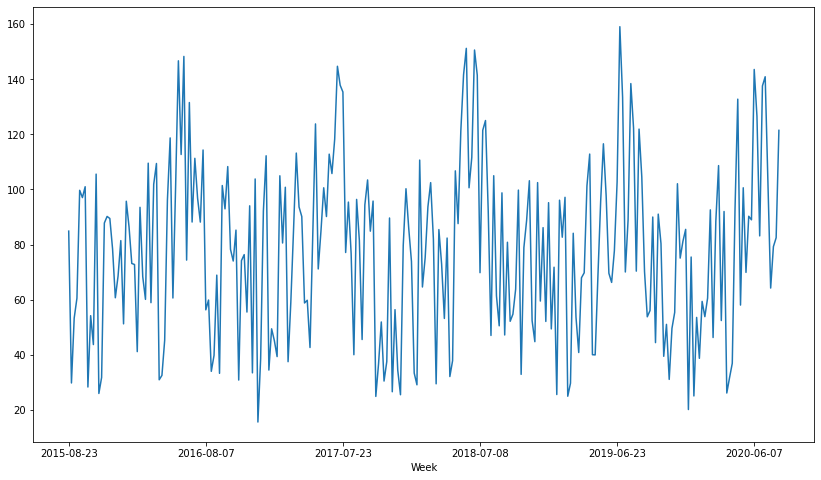

In [3]:
df["Sales"].plot()

Split dataset into train and test parts.

In [4]:
train_set_ratio = 0.8

df_train, df_test = train_test_split(df, test_size = 1 - train_set_ratio)

print(f"Train set size: {df_train.shape[0]}; test set size: {df_test.shape[0]}")

Train set size: 208; test set size: 52


### Train Forecasting Models

Implement Mean Absolute Percentage Error.

In [5]:
def mape(y, y_hat):
    assert y.shape[0] == y_hat.shape[0]
    return np.mean(np.abs(y_hat - y) / np.maximum(np.abs(y), 1e-6))

Function that converts strings to week numbers. It's useful while inference of SalesPredictor model, since it receives week number as a first argument.

In [6]:
def weeks_from_date(date_strings):
    return pd.Series(date_strings) \
             .apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").isocalendar()[1]) \
             .to_numpy()

In [7]:
class SalesPredictor:
    def __init__(self, period, residuals_model):
        self.period = period
        self.residuals_model = residuals_model
    
    def fit(self, prices, sales):
        decomposition = seasonal_decompose(sales, model='additive', period=self.period)
        self.seasonal, trend, res = decomposition.seasonal, decomposition.trend, decomposition.resid
        self.first_week = weeks_from_date(self.seasonal.index)[0]
        
        trend = trend[~trend.isna()]
        # self._fit_trend(np.arange(trend.shape[0]), trend)
        
        res = res[~res.isna()]
        prices = prices.loc[res.index]
        
        self.residuals_model.fit(
            pd.DataFrame(
                data={
                    "prices": prices.to_numpy(),
                    "week": weeks_from_date(prices.index)
            }),
            (res + trend).to_numpy().reshape(-1, 1)
        )

    # def _fit_trend(self, x, y):
    #     slope, intercept = np.polyfit(x, y, deg=1)
    #     self.trend_slope = slope
    #     self.trend_intercept = intercept
    
    def _predict_array(self, week, prices, verbose: bool = False):
        seasonal_pred = self.seasonal[(week - self.first_week) % 53]
        # pred_trend = self.trend_slope * week + self.trend_intercept
        
        pred_res = self.residuals_model.predict(
            pd.DataFrame(data={
                    "prices": prices.to_numpy(), 
                    "week": week, 
            }))
        
        if pred_res.ndim > 1:
            pred_res = pred_res.squeeze(1)
            
        # if verbose:
        #     fig, ax = plt.subplots(3, 1, figsize=(25, 6))
        #     ax[0].plot(prices.index, seasonal_pred)
        #     ax[1].plot(prices.index, pred_trend)
        #     ax[2].plot(prices.index, pred_res)
        #     plt.show()
        
        # return seasonal_pred + pred_trend + pred_res
        return seasonal_pred + pred_res
    
    def predict(self, week, prices, verbose: bool = False):
        if not isinstance(week, np.ndarray) and not isinstance(prices, np.ndarray):
            sales_pred = self._predict_array(np.array([week]), np.array([[prices]]), verbose)
            return sales_pred[0]
        return self._predict_array(week, prices, verbose)


In [8]:
data_path = os.path.join("data", "sales_data.csv")
df = pd.read_csv(data_path, index_col=0)
    
sp = SalesPredictor(period=52, residuals_model=Lasso())
prices, sales = df_train["Price"], df_train["Sales"]
sp.fit(prices, sales)

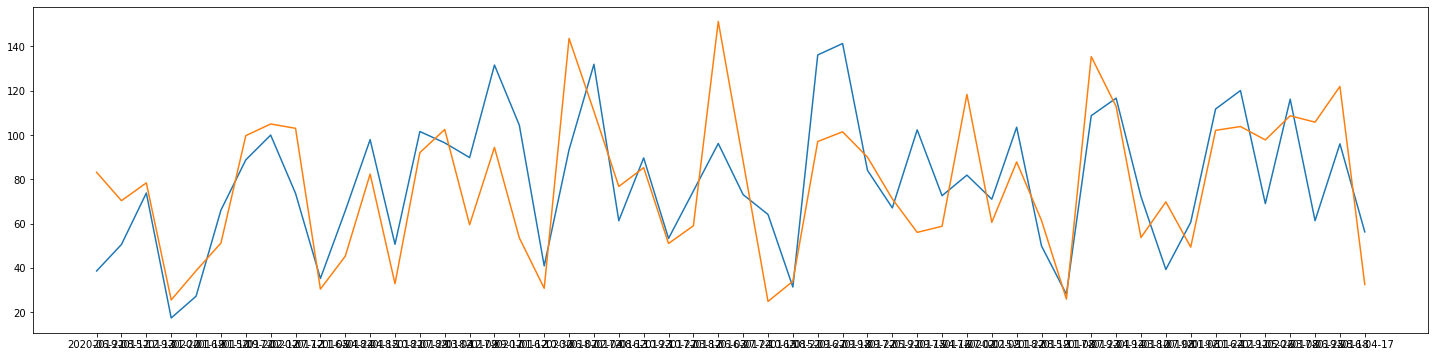

In [9]:
sales_hat = sp.predict(weeks_from_date(df_test.index), df_test["Price"], verbose=True)

fig, ax = plt.subplots(1, 1, figsize=(25, 6))
ax.plot(df_test.index, sales_hat)
ax.plot(df_test.index, df_test["Sales"])

Implement model validation function, using sliding window cross-validation approach. Use MAPE score as a performance metric.

In [10]:
from typing import Union, List

def validate(
    model,
    df: pd.DataFrame,
    folds_number: int,
    samples_per_fold: int,
    forecasting_horison: int = 5, 
    reduce: bool = True
) -> Union[List[float], float]:
    
    mape_scores = []
    for i in range(folds_number):
        start_index = i * samples_per_fold
        end_index = start_index + samples_per_fold + forecasting_horison
        if end_index >= df.shape[0]:
            break
        
        X_train = df.iloc[start_index:end_index-forecasting_horison, :-1]
        y_train = df.iloc[start_index:end_index-forecasting_horison, -1]
        X_val = df.iloc[end_index-forecasting_horison:end_index, :-1]
        y_val = df.iloc[end_index-forecasting_horison:end_index, -1]
  
        predictor = SalesPredictor(52, model)
        prices, sales = df_train["Price"], df_train["Sales"]
        
        predictor.fit(prices, sales)
        
        y_pred = predictor.predict(
            weeks_from_date(X_val.index),
            X_val["Price"]
        )
        
        mape_scores.append(mape(y_val.to_numpy(), y_pred.to_numpy()))
    
    if reduce:
        return np.mean(mape_scores), predictor
    else:
        return mape_scores, predictor


Validate different linear models, such that linear regression, ridge and lasso. Try nonlinear estimators.
Can you explain why linear estimators perform better?
Use SalesPredictor class for defining models. It allows incapsulating seasonality extraction procedure.

In [11]:
period = 52
folds_number = 4
samples_per_fold = 104


models_to_test = [
    sklearn.linear_model.Lasso(), 
    sklearn.linear_model.LinearRegression(), 
    sklearn.linear_model.Ridge(), 
    sklearn.svm.LinearSVR(), 
    # sklearn.ensemble.RandomForestRegressor()
]

best_err = float("inf")
best_model = None

for idx, model in enumerate(models_to_test):
    err, sp_model = validate(model, df_train, folds_number, samples_per_fold)
    print(model.__class__.__name__, err)
    if err < best_err:
        best_err = err
        best_model = sp_model
    
f"{best_err=}; {best_model.__class__.__name__}"

Lasso 0.30303271793936004
LinearRegression 0.302006382188444
Ridge 0.3020072225042205
LinearSVR 1.4265605245719621


'best_err=0.302006382188444; SalesPredictor'

### Evaluate on Test set


Make predictions on test set.

In [12]:
sales_hat = best_model.predict(weeks_from_date(df_test.index), df_test["Price"])

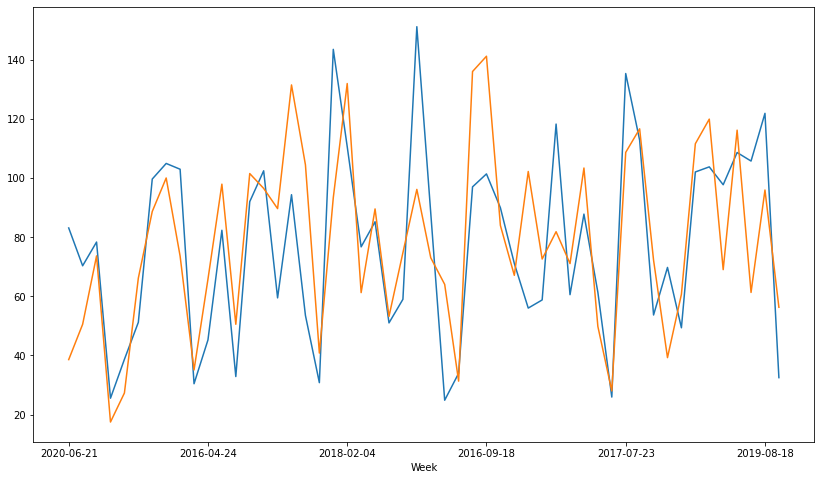

In [13]:
df_test["Sales"].plot()
plt.plot(df_test.index, sales_hat)

In [14]:
print(f"MAPE = {mape(df_test['Sales'].to_numpy(), sales_hat.to_numpy())}")

MAPE = 0.2944611652759896


### Save Model

In [15]:
best_model.fit(df["Price"], df["Sales"])

In [16]:
model_path = os.path.join("data", "sales_model.pkl")
pickle.dump(best_model, open(model_path, "wb"))